# To Replicate Test:
This tests if the residuals are distributed as our model predicts them to be

In [1]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import time

from scipy.stats import norm, skewnorm, gamma
%load_ext autoreload
%autoreload 2

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import KoopmanProb
from model_objs import GammaNLL, SkewNormalNLL

In [4]:
def pinball_loss(data, quant_preds, quantiles):
    assert(len(data) == len(quant_preds))
    loss = 0
    for t in range(len(data)):
        for i in range(len(quantiles)):
            q = quantiles[i]
            quant_pred = quant_preds[t][i]
            if quant_pred > data[t]:
                loss += (quant_pred - data[t]) * (1 - q)
            else:
                loss += (data[t] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [5]:
def nmb(data, pred):
    """Normalized mean bias"""
    assert(len(data) == len(pred))
    return np.mean(pred - data) / np.mean(data)

def nrmse(data, pred):
    """Normalized root mean square error"""
    assert(len(data) == len(pred))
    sorted_data = sorted(data)
    o05 = sorted_data[int(len(data) * 0.05)]
    o95 = sorted_data[int(len(data) * 0.95)]
    return np.sqrt(np.mean((data - pred)**2)) / (o95 - o05)

from scipy.stats import pearsonr
def correlation(data, pred):
    """Pearson correlation"""
    assert(len(data) == len(pred))
    return pearsonr(data, pred)[0]    

In [6]:
station_path = ".\\atmo_chem\\stations\\"
station_name = "EEA_DE_DE_DEBY089"  # randomly selected

In [7]:
obsfile = os.path.join(station_path, 'obs_%s.csv'.replace('%s',station_name))
obs = pd.read_csv(obsfile, parse_dates=['ISO8601',], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
obs["t"] = [time.mktime(obs.ISO8601.iloc[i].timetuple()) for i in range(len(obs))]
t_min = obs.t.min()
obs.t -= t_min
obs_no2 = obs.loc[obs.obstype=='no2']
obs_o3 = obs.loc[obs.obstype=='o3']
obs_pm25 = obs.loc[obs.obstype=='pm25']
 
modfile = os.path.join(station_path, 'model_forecast_%s.csv'.replace('%s',station_name))
mod = pd.read_csv(modfile, parse_dates=['ISO8601','ISO8601_init'],date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601_init','ISO8601'])
mod["t"] = [time.mktime(mod.ISO8601.iloc[i].timetuple()) for i in range(len(mod))]
mod.t -= t_min

In [8]:
len(obs_no2), len(obs_o3), len(obs_pm25)

(27978, 27901, 20912)

In [9]:
obs

,ISO8601,original_station_name,lat,lon,obstype,conc_obs,conc_obs.1,conc_unit,t
0,2017-12-31 23:00:00,EEA_DE_DE_DEBY089,48.1732,11.648,no2,21.6356,21.6356,ppbv,0.0
1,2017-12-31 23:00:00,EEA_DE_DE_DEBY089,48.1732,11.648,o3,3.3056,3.3056,ppbv,0.0
2,2017-12-31 23:00:00,EEA_DE_DE_DEBY089,48.1732,11.648,pm25,380.0330,380.0330,ugm-3,0.0
3,2018-01-01 00:00:00,EEA_DE_DE_DEBY089,48.1732,11.648,no2,15.9093,15.9093,ppbv,3600.0
4,2018-01-01 00:00:00,EEA_DE_DE_DEBY089,48.1732,11.648,o3,14.2117,14.2117,ppbv,3600.0
...,...,...,...,...,...,...,...,...,...
76786,2021-03-15 21:00:00,EEA_DE_DE_DEBY089,48.1732,11.648,o3,26.6800,26.6800,ppbv,101077200.0
76787,2021-03-15 22:00:00,EEA_DE_DE_DEBY089,48.1732,11.648,no2,5.1436,5.1436,ppbv,101080800.0
76788,2021-03-15 22:00:00,EEA_DE_DE_DEBY089,48.1732,11.648,o3,28.3550,28.3550,ppbv,101080800.0
76789,2021-03-15 23:00:00,EEA_DE_DE_DEBY089,48.1732,11.648,no2,5.3085,5.3085,ppbv,101084400.0


In [10]:
mod

,ISO8601_init,ISO8601,location,lat,lon,NO2,O3,PM25_RH35_GCC,t
0,2019-01-01,2019-01-01 12:30:00,EEA_DE_DE_DEBY089,48.1732,11.648,5.660763e-09,2.211891e-08,25.016127,31584600.0
1,2019-01-01,2019-01-01 13:30:00,EEA_DE_DE_DEBY089,48.1732,11.648,5.493405e-09,2.334127e-08,21.847168,31588200.0
2,2019-01-01,2019-01-01 14:30:00,EEA_DE_DE_DEBY089,48.1732,11.648,5.660750e-09,2.491288e-08,20.157700,31591800.0
3,2019-01-01,2019-01-01 15:30:00,EEA_DE_DE_DEBY089,48.1732,11.648,5.893566e-09,2.575689e-08,20.158491,31595400.0
4,2019-01-01,2019-01-01 16:30:00,EEA_DE_DE_DEBY089,48.1732,11.648,6.039086e-09,2.587331e-08,22.075287,31599000.0
...,...,...,...,...,...,...,...,...,...
43550,2019-12-31,2020-01-05 07:30:00,EEA_DE_DE_DEBY089,48.1732,11.648,5.209623e-09,2.217728e-08,14.993513,63448200.0
43551,2019-12-31,2020-01-05 08:30:00,EEA_DE_DE_DEBY089,48.1732,11.648,5.464278e-09,2.188672e-08,14.895976,63451800.0
43552,2019-12-31,2020-01-05 09:30:00,EEA_DE_DE_DEBY089,48.1732,11.648,4.554780e-09,2.322487e-08,14.614159,63455400.0
43553,2019-12-31,2020-01-05 10:30:00,EEA_DE_DE_DEBY089,48.1732,11.648,3.281488e-09,2.578599e-08,12.303943,63459000.0


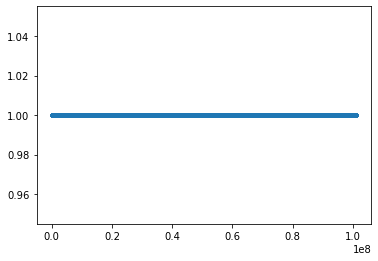

In [11]:
plt.figure()
plt.plot(obs.t, np.ones(len(obs.t)), ".")

In [12]:
diff = -(pd.to_datetime(mod.ISO8601_init) - pd.to_datetime(mod.ISO8601))
five_day_mod = mod[(diff > dt.timedelta(days=4)) & (diff < dt.timedelta(days=5))]
mods = dict()
for num_ahead in range(1, 6):
    mods[f"ahead{num_ahead}"] = mod[(diff > dt.timedelta(days=num_ahead - 0.5)) & (diff < dt.timedelta(days=num_ahead + 0.5))]

In [13]:
mods_no2 = [mods[x].NO2.values[:8707] for x in mods.keys()]
mods_no2 = np.array(mods_no2).T
mods_o3 = [mods[x].O3.values[:8707] for x in mods.keys()]
mods_o3 = np.array(mods_o3).T
mods_pm25 = [mods[x].PM25_RH35_GCC.values[:8707] for x in mods.keys()]
mods_pm25 = np.array(mods_pm25).T

In [14]:
mods_no2.shape,mods_o3.shape,mods_pm25.shape,

((8707, 5), (8707, 5), (8707, 5))

In [15]:
chemical = "NO2"
x = np.expand_dims(obs_no2.conc_obs.values, -1)
t = obs_no2.t.values
print("x", x.shape)
print("t", t.shape)

x (27978, 1)
t (27978,)


In [16]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [17]:
if x.min() <= 0:
    print("negative observed concentration: ", x[x<=0])
    x[x <= 0] = 1e-20

In [18]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (27978, 1)
t (27978,)


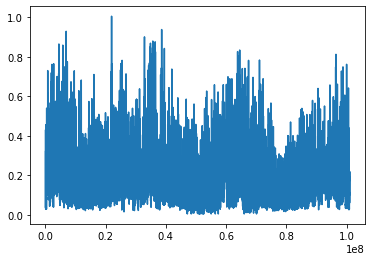

In [19]:
plt.figure()
plt.plot(t, x)

In [20]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [21]:
data_name = chemical + station_name

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (27978, 1)
xt (8750, 1)


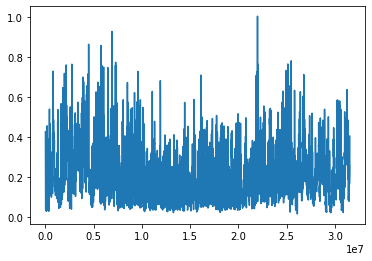

In [22]:
plt.figure()
plt.plot(tt, xt)

In [23]:
mod_quant_preds = 1e9 / rnge * (mods_no2[1:, :] + mods_no2[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60  # because interpolating 30 minutes
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t and (i == 0 or modst[i] != modst[i - 1])]

In [24]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [25]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [26]:
k.fit(xt, tt, iterations=2_000_000 // xt.shape[0], interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.19466732
Iteration  1
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.21685453
Iteration  2
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.23617503
Iteration  3
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.25304344
Iteration  4
tensor([   86400.,   604800., 31557600.,    86400.,   60480

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5719935
Iteration  36
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5794651
Iteration  37
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.58739805
Iteration  38
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5946182
Iteration  39
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400., 

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.76511484
Iteration  72
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.7681943
Iteration  73
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.7713475
Iteration  74
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.77380306
Iteration  75
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.83227605
Iteration  108
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.8335454
Iteration  109
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.83405924
Iteration  110
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.8352735
Iteration  111
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.85673785
Iteration  144
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.85716355
Iteration  145
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.85688496
Iteration  146
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.8581615
Iteration  147
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.87076414
Iteration  180
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.87085855
Iteration  181
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.8717927
Iteration  182
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.87281525
Iteration  183
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.8830611
Iteration  216
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.8827159
Iteration  217
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.88332
Iteration  218
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.88412845
Iteration  219
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

In [27]:
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set and (i == 0 or t[i] != t[i - 1])])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

In [28]:
tt[-1]

31536000.0

In [29]:
test_ts[0]

31586400.0

## Get Quantiles

In [30]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [31]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

In [32]:
# for figure
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
#     plt.figure(dpi=150)
    plt.subplots(figsize=[3,4], dpi=150)
    plt.subplot(111)
#     marker=(2, 0, 0)
    plt.plot(test_ts, x[koopman_test_idxs], linestyle="--", linewidth=1, label="data")

#     colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
#     plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
#     for j in range(1, len(quantiles), 1):
#         plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
#     plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
#     for j in range(1, len(quantiles), 1):
#         plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 2], color=colors[2], linewidth=1.3, label="GEOS-CF median")
        
    plt.plot(test_ts, mean_hat[:, dim], label="dPK $\hat \mu$", linewidth=2.1)
    plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="dPK $\hat \mu \pm \hat \sigma$", linewidth=0.5)
    plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title("NO$_2$", fontsize=18)
    plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    plt.xlabel("t", fontsize=14)
    plt.ylabel("concentration", fontsize=14)
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>

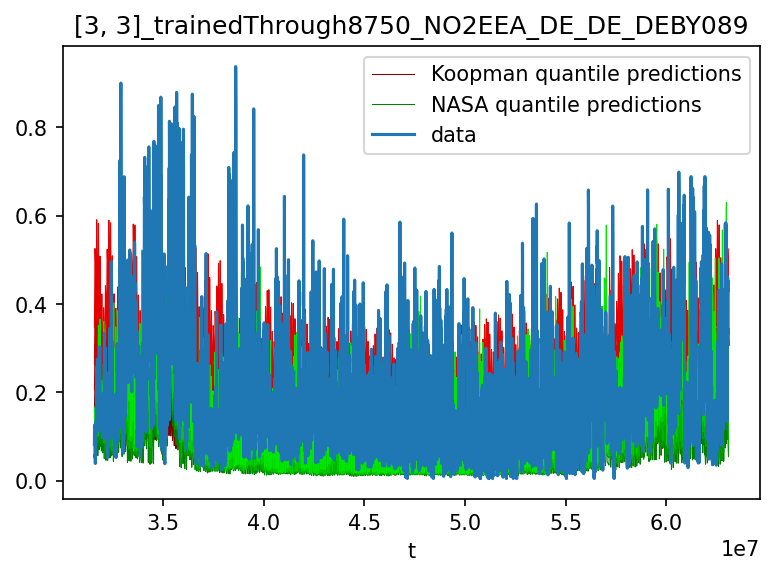

In [33]:
%matplotlib inline

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [34]:
transformed_a = a_hat.mean()
transformed_scale = (1/rate_hat).mean()

cumulative_probs = gamma.cdf(x[koopman_test_idxs], a=a_hat, scale=1/rate_hat)
transformed_residuals = gamma.ppf(cumulative_probs, a=transformed_a, scale=transformed_scale)

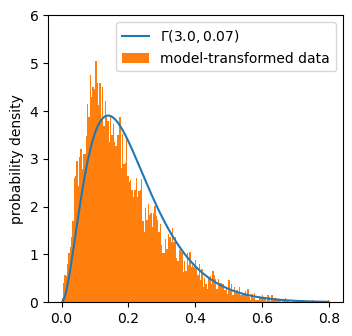

In [37]:
%matplotlib inline
fig = plt.figure(figsize=(3.8, 3.8), dpi=100)
ax = fig.add_subplot()
bin_edges = np.linspace(0, 0.8, 200)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
pdf = gamma.pdf(bin_centers, a=transformed_a, scale=transformed_scale)
ax.plot(bin_centers, pdf, label=f"$\Gamma({str(np.round(transformed_a, 1))}, {str(np.round(transformed_scale, 2))})$")
ax.hist(transformed_residuals, density=True, bins=bin_edges, label="model-transformed data");
ax.set_ylabel("probability density")
ax.set_ylim([0, 6])
ax.legend()

In [38]:
fig.savefig(station_name + "_NO2_calibration.svg")

<IPython.core.display.Javascript object>


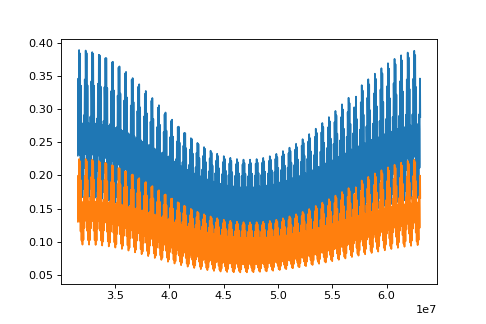

In [39]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

In [40]:
del x, xt, t, tt

# CHEMICAL O3
## GET CHEMICAL

In [41]:
chemical = "O3"
x = np.expand_dims(obs_o3.conc_obs.values, -1)
t = obs_o3.t.values
print("x", x.shape)
print("t", t.shape)

x (27901, 1)
t (27901,)


In [42]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [43]:
if x.min() <= 0:
    print("negative observed concentration: ", x[x<=0])
    x[x <= 0] = 1e-20

In [44]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (27901, 1)
t (27901,)


<IPython.core.display.Javascript object>


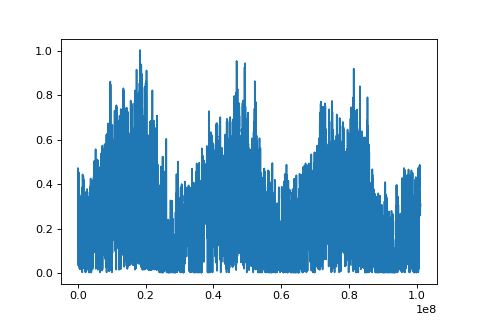

In [45]:
plt.figure()
plt.plot(t, x)

In [47]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [48]:
data_name = chemical + station_name

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (27901, 1)
xt (8746, 1)


In [49]:
mod_quant_preds = 1e9 / rnge * (mods_o3[1:, :] + mods_o3[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t and (i == 0 or modst[i] != modst[i - 1])]

In [50]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [51]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [52]:
k.fit(xt, tt, iterations=2_000_000 // xt.shape[0], interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.1470818
Iteration  1
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.1614952
Iteration  2
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.17382494
Iteration  3
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.18556085
Iteration  4
tensor([   86400.,   604800., 31557600.,    86400.,   604800.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.3962839
Iteration  36
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.40096375
Iteration  37
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.40545362
Iteration  38
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.40931743
Iteration  39
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.51285243
Iteration  72
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5151252
Iteration  73
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5174052
Iteration  74
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5189386
Iteration  75
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400., 

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.56218696
Iteration  108
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.563536
Iteration  109
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5638278
Iteration  110
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.56470543
Iteration  111
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8640

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.58463305
Iteration  144
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.58534193
Iteration  145
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5853194
Iteration  146
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5855072
Iteration  147
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5965823
Iteration  180
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.5964814
Iteration  181
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.59642345
Iteration  182
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.59708434
Iteration  183
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    864

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6055551
Iteration  216
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6054368
Iteration  217
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.6056281
Iteration  218
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  -0.60593325
Iteration  219
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    8640

In [53]:
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set and (i == 0 or t[i] != t[i - 1])])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [54]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [55]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

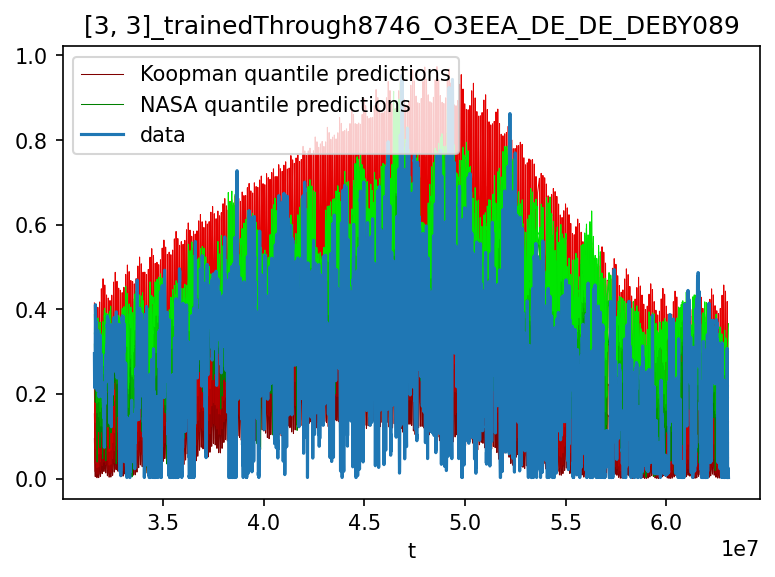

In [56]:
%matplotlib inline

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [57]:
transformed_a = a_hat.mean()
transformed_scale = (1/rate_hat).mean()

cumulative_probs = gamma.cdf(x[koopman_test_idxs], a=a_hat, scale=1/rate_hat)
transformed_residuals = gamma.ppf(cumulative_probs, a=transformed_a, scale=transformed_scale)

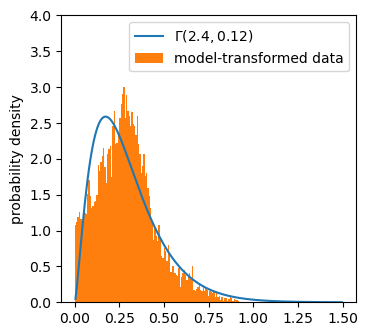

In [60]:
%matplotlib inline
fig = plt.figure(figsize=(3.8, 3.8), dpi=100)
ax = fig.add_subplot()
bin_edges = np.linspace(0, 1.5, 200)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
pdf = gamma.pdf(bin_centers, a=transformed_a, scale=transformed_scale)
ax.plot(bin_centers, pdf, label=f"$\Gamma({str(np.round(transformed_a, 1))}, {str(np.round(transformed_scale, 2))})$")
ax.hist(transformed_residuals, density=True, bins=bin_edges, label="model-transformed data");
ax.set_ylabel("probability density")
ax.set_ylim([0, 4])
ax.legend()

In [61]:
fig.savefig(station_name + "_O3_calibration.svg")

<IPython.core.display.Javascript object>


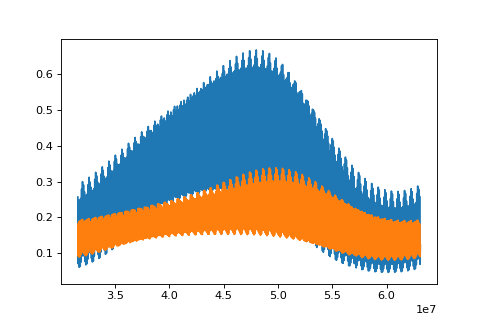

In [62]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")

In [63]:
del x, xt, t, tt

# CHEMICAL PM25
## GET CHEMICAL

In [64]:
chemical = "PM25"
x = np.expand_dims(obs_pm25.conc_obs.values, -1)
t = obs_pm25.t.values
print("x", x.shape)
print("t", t.shape)

x (20912, 1)
t (20912,)


In [65]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [66]:
if x.min() <= 0:
    print("negative observed concentration: ", x[x <= 0])
    x[x <= 0] = 1e-20

In [67]:
x_original = x
rnge = np.std(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)
print("t", t.shape)

x (20912, 1)
t (20912,)


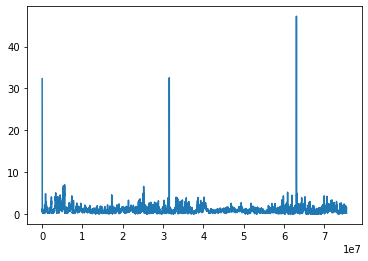

In [68]:
%matplotlib inline
plt.figure()
plt.plot(t, x)

In [69]:
train_through = np.argwhere(1 * 365 * 24 * 60 * 60 < t)[0, 0]

In [70]:
data_name = chemical + station_name

train_start = 0
delay = 0
x = x[train_start:]
t = t[train_start:]
predict_through = len(t)  # all of it  
x = x[:predict_through]
xt = x[:train_through]
tt = t[:train_through]

num_freqs = [3, 3]
num_fourier = 3
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (20912, 1)
xt (8732, 1)


In [71]:
mod_quant_preds = 1 / rnge * (mods_pm25[1:, :] + mods_pm25[:-1, :]) / 2
mod_quant_preds.sort(axis=1)
modst = mods["ahead1"].t.values[:8706] + 30 * 60
set_t = set(t)
mod_test_idxs = [i for i in range(8706) if modst[i] in set_t and (i == 0 or modst[i] != modst[i - 1])]

In [72]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [73]:
k.find_fourier_omegas(xt, tt, hard_code=[24 * 60 * 60, 24 * 60 * 60 * 7, 24 * 365.25 * 60 * 60])  # Day, Year, week

fourier periods: tensor([   86399.9978,   604799.9694, 31557599.3107], dtype=torch.float64)


tensor([7.2722e-05, 1.0389e-05, 1.9910e-07], dtype=torch.float64)

In [74]:
k.fit(xt, tt, iterations=2_000_000 // xt.shape[0], interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.430286
Iteration  1
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.3228109
Iteration  2
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.2418923
Iteration  3
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  1.1753862
Iteration  4
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.92162216
Iteration  37
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.9200287
Iteration  38
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.9189486
Iteration  39
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.9174442
Iteration  40
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   60

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.88612694
Iteration  73
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.88547546
Iteration  74
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8844205
Iteration  75
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8829547
Iteration  76
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   6

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8638517
Iteration  109
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.86387813
Iteration  110
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8616593
Iteration  111
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8622679
Iteration  112
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400., 

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.84748495
Iteration  145
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.84603614
Iteration  146
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.84729624
Iteration  147
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.848124
Iteration  148
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8376612
Iteration  181
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8357652
Iteration  182
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.83538944
Iteration  183
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8356676
Iteration  184
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400., 

Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8273716
Iteration  217
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.826291
Iteration  218
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8259394
Iteration  219
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.],
       grad_fn=<MulBackward0>)
Loss:  0.8276403
Iteration  220
tensor([   86400.,   604800., 31557600.,    86400.,   604800., 31557600.])
Setting periods to tensor([   86400.,   604800., 31557600.,    86400.,   

In [75]:
tt.astype(int)

array([       0,     3600,     7200, ..., 31528800, 31532400, 31536000])

In [76]:
tt[-1] / (365 * 24 * 60 * 60)

1.0

In [77]:
test_ts[-1] / (365 * 24 * 60 * 60)

2.000799086757991

In [78]:
len(xt), len(koopman_test_idxs)

(8732, 8670)

In [79]:
test_ts_set = set(modst[mod_test_idxs])
koopman_test_idxs = np.array([i for i in range(len(t)) if t[i] in test_ts_set and (i == 0 or t[i] != t[i - 1])])
test_ts = t[koopman_test_idxs]
params = k.predict(test_ts)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [80]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [81]:
quantiles = np.arange(1, 6, dtype=np.float32) / 6
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

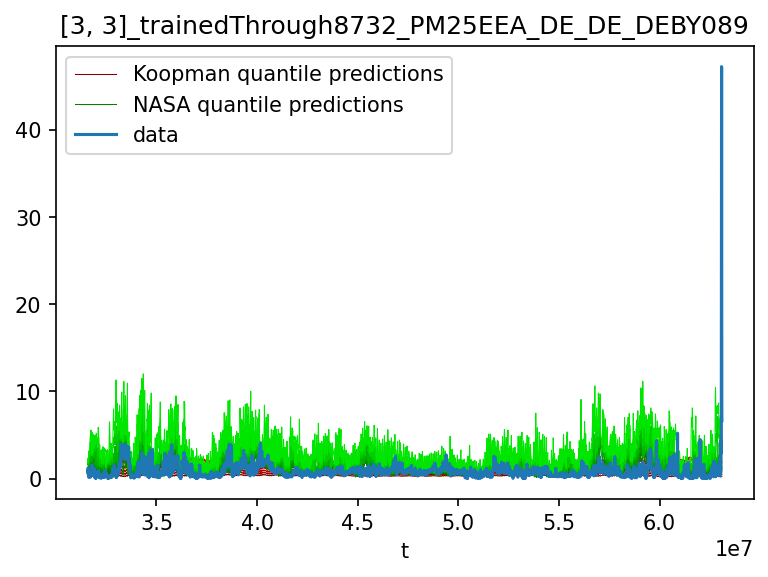

In [82]:
%matplotlib inline

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    colors = [((i + 5) / (len(quantiles) + 5), 0, 0) for i in range(len(quantiles))]
    plt.plot(test_ts, quant_preds[:, 0], color=colors[0], linewidth=0.5, label="Koopman quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, quant_preds[:, j], color=colors[j], linewidth=0.5)
    
    colors = [(0, (i + 5) / (len(quantiles) + 5), 0) for i in range(len(quantiles))]
    plt.plot(test_ts, mod_quant_preds[mod_test_idxs, 0], color=colors[0], linewidth=0.5, label="NASA quantile predictions")
    for j in range(1, len(quantiles), 1):
        plt.plot(test_ts, mod_quant_preds[mod_test_idxs, j], color=colors[j], linewidth=0.5)
    
    plt.plot(test_ts, x[koopman_test_idxs], label="data")

        
#     plt.plot(test_ts, mean_hat[:, dim], label="Koopman mean", linewidth=1)
#     plt.plot(test_ts, mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
#     plt.plot(test_ts, mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [83]:
transformed_a = a_hat.mean()
transformed_scale = (1/rate_hat).mean()

cumulative_probs = gamma.cdf(x[koopman_test_idxs], a=a_hat, scale=1/rate_hat)
transformed_residuals = gamma.ppf(cumulative_probs, a=transformed_a, scale=transformed_scale)

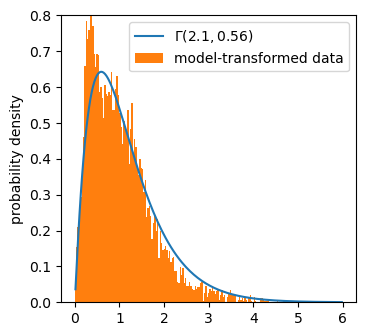

In [91]:
%matplotlib inline
fig = plt.figure(figsize=(3.8, 3.8), dpi=100)
ax = fig.add_subplot()
bin_edges = np.linspace(0, 6, 200)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
pdf = gamma.pdf(bin_centers, a=transformed_a, scale=transformed_scale)
ax.plot(bin_centers, pdf, label=f"$\Gamma({str(np.round(transformed_a, 1))}, {str(np.round(transformed_scale, 2))})$")
ax.hist(transformed_residuals, density=True, bins=bin_edges, label="model-transformed data");
ax.set_ylabel("probability density")
ax.set_ylim([0, 0.8])
ax.legend()

In [92]:
fig.savefig(station_name + "_PM25_calibration.svg")

<IPython.core.display.Javascript object>


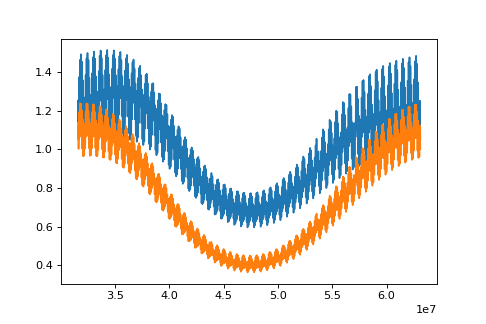

In [86]:
%matplotlib notebook
plt.plot(test_ts, mean_hat)
plt.plot(test_ts, std_hat)
# plt.plot(1/rate_hat, color="c")